<a href="https://colab.research.google.com/github/Kaykayag/hgraph2graph/blob/master/Part_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import os

# Only mount Drive if we are actually in Colab
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    # Path to your drive folder
    os.chdir('/content/drive/MyDrive/FreeAi')
else:

    print("Running locally.")

Mounted at /content/drive


In [ ]:
%cd hgraph2graph

/content/drive/.shortcut-targets-by-id/1r9JSogipHdtnF8Ba8PnGdHfNnOiszJbA/FreeAi/hgraph2graph


In [ ]:
!pip install torch rdkit networkx numpy pandas matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 63.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit import DataStructs

lg = rdkit.RDLogger.logger()
lg.setLevel(rdkit.RDLogger.CRITICAL)

import sys
# sys.path.insert(0, '/content/hgraph2graph')
from hgraph import HierVAE, MolGraph, common_atom_vocab, PairVocab
from hgraph import MoleculeDataset
import hgraph.hgnn as hgnn_module

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Patch make_cuda
def make_cuda_fixed(tensors):
    tree_tensors, graph_tensors = tensors
    def make_tensor(x):
        if isinstance(x, torch.Tensor):
            return x
        elif isinstance(x, np.ndarray):
            return torch.from_numpy(x)
        else:
            return torch.tensor(x)
    tree_tensors = [make_tensor(x).to(device).long() for x in tree_tensors[:-1]] + [tree_tensors[-1]]
    graph_tensors = [make_tensor(x).to(device).long() for x in graph_tensors[:-1]] + [graph_tensors[-1]]
    return tree_tensors, graph_tensors

hgnn_module.make_cuda = make_cuda_fixed

# Set seeds
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

print("✅ Part C setup complete!")

✅ Part C setup complete!


In [ ]:
# Load Model and Prepare Data
# Load vocabulary
vocab_path = 'data/chembl/vocab.txt'
vocab_list = [x.strip("\r\n ").split() for x in open(vocab_path)]
vocab = PairVocab(vocab_list)

# Model args
class Args:
    def __init__(self):
        self.vocab = vocab
        self.atom_vocab = common_atom_vocab
        self.rnn_type = 'LSTM'
        self.hidden_size = 250
        self.embed_size = 250
        self.batch_size = 20
        self.latent_size = 32
        self.depthT = 15
        self.depthG = 15
        self.diterT = 1
        self.diterG = 3
        self.dropout = 0.0

args = Args()

# Load pretrained model
model = HierVAE(args).to(device)
pretrained_path = 'ckpt/chembl-pretrained/model.ckpt'
checkpoint = torch.load(pretrained_path, map_location=device)
pretrained_state = checkpoint[0] if isinstance(checkpoint, tuple) else checkpoint
model.load_state_dict(pretrained_state)
model.eval()

print("✅ Model loaded!")

# Prepare test molecules
with open('data/chembl/all.txt', 'r') as f:
    all_smiles = [line.strip() for line in f][: 2000]

def filter_smiles(smiles_list, vocab, max_count=300):
    """Filter molecules compatible with vocabulary."""
    valid = []
    for smi in tqdm(smiles_list, desc="Filtering molecules"):
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol is None or mol.GetNumAtoms() > 40 or mol.GetNumAtoms() < 5:
                continue
            Chem.Kekulize(mol, clearAromaticFlags=False)
            hmol = MolGraph(smi)
            ok = True
            for node, attr in hmol.mol_tree.nodes(data=True):
                smiles_node = attr['smiles']
                ok &= attr['label'] in vocab.vmap
                for i, s in attr['inter_label']:
                    ok &= (smiles_node, s) in vocab.vmap
                if not ok:
                    break
            if ok:
                valid.append(smi)
                if len(valid) >= max_count:
                    break
        except:
            continue
    return valid

test_smiles = filter_smiles(all_smiles, vocab, max_count=250)
print(f"✅ Test molecules prepared: {len(test_smiles)}")

✅ Model loaded!


Filtering molecules:  18%|█▊        | 359/2000 [00:04<00:18, 87.70it/s] 

✅ Test molecules prepared: 250


In [ ]:
# Define Forward Hooks for Hidden State Capture
class DecoderProbe:
    """
    Captures intermediate decoder representations using forward hooks.

    The hgraph2graph decoder has these key stages:
    1. ENCODER OUTPUT (root_vecs) - Initial latent representation
    2. TOPOLOGY DECISION (topoNN) - Decides whether to expand tree
    3. CLUSTER PREDICTION (clsNN) - Predicts which motif/cluster to add
    4. INTER-CLUSTER PREDICTION (iclsNN) - Predicts attachment interface
    5. ASSEMBLY SCORING (matchNN + W_assm) - Scores attachment candidates
    """

    def __init__(self, model):
        self.model = model
        self.decoder = model.decoder
        self.captured_states = {}
        self.hooks = []

    def _make_hook(self, name):
        """Create a forward hook that captures layer outputs."""
        def hook(module, input, output):
            if isinstance(output, torch.Tensor):
                self.captured_states[name] = output.detach().cpu()
            elif isinstance(output, tuple):
                self.captured_states[name] = output[0].detach().cpu() if isinstance(output[0], torch. Tensor) else None
        return hook

    def register_hooks(self):
        """Register hooks on key decoder components."""
        # Clear previous hooks
        self. remove_hooks()

        # Hook 1: Topology prediction network (early decoder)
        hook = self.decoder.topoNN.register_forward_hook(self._make_hook('topo_hidden'))
        self.hooks.append(hook)

        # Hook 2: Cluster prediction network (mid decoder)
        hook = self.decoder.clsNN.register_forward_hook(self._make_hook('cls_hidden'))
        self.hooks.append(hook)

        # Hook 3: Inter-cluster prediction network (mid decoder)
        hook = self.decoder.iclsNN. register_forward_hook(self._make_hook('icls_hidden'))
        self.hooks.append(hook)

        # Hook 4: Assembly matching network (late decoder)
        hook = self.decoder.matchNN.register_forward_hook(self._make_hook('assm_hidden'))
        self.hooks.append(hook)

        # Hook 5: W_assm projection (final assembly)
        hook = self.decoder.W_assm.register_forward_hook(self._make_hook('assm_proj'))
        self.hooks.append(hook)

        print(f"✅ Registered {len(self.hooks)} forward hooks on decoder")

    def remove_hooks(self):
        """Remove all registered hooks."""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

    def clear_states(self):
        """Clear captured states."""
        self.captured_states = {}

    def get_states(self):
        """Get all captured states."""
        return self.captured_states.copy()

# Create probe
probe = DecoderProbe(model)
probe.register_hooks()

print("✅ Decoder hooks registered!")
print("\nDecoder stages being probed:")
print("  1. topoNN - Topology prediction (expand/stop decision)")
print("  2. clsNN - Cluster/motif prediction")
print("  3. iclsNN - Inter-cluster interface prediction")
print("  4. matchNN - Attachment matching")
print("  5. W_assm - Assembly projection (final)")

✅ Registered 5 forward hooks on decoder
✅ Decoder hooks registered!

Decoder stages being probed:
  1. topoNN - Topology prediction (expand/stop decision)
  2. clsNN - Cluster/motif prediction
  3. iclsNN - Inter-cluster interface prediction
  4. matchNN - Attachment matching
  5. W_assm - Assembly projection (final)


In [ ]:
# Extract Decoder Representations
def get_molecular_properties(smiles):
    """Extract target properties for probing."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    try:
        return {
            'num_atoms': mol.GetNumAtoms(),
            'num_bonds': mol.GetNumBonds(),
            'num_rings':  Chem.GetSSSR(mol).__len__(),
            'num_aromatic_rings':  Descriptors.NumAromaticRings(mol),
            'num_heteroatoms':  Descriptors.NumHeteroatoms(mol),
            'molecular_weight': Descriptors.MolWt(mol),
            'logp': Descriptors.MolLogP(mol),
            'tpsa': Descriptors.TPSA(mol),
            'num_rotatable_bonds':  Descriptors.NumRotatableBonds(mol),
            'num_hbd': Descriptors.NumHDonors(mol),
            'num_hba': Descriptors.NumHAcceptors(mol),
        }
    except:
        return None

def extract_encoder_representations(model, smiles_list, vocab, atom_vocab, batch_size=10):
    """
    Extract encoder representations (root_vecs) for molecules.
    These serve as the initial decoder input.
    """
    dataset = MoleculeDataset(smiles_list, vocab, atom_vocab, batch_size)
    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0,
                       collate_fn=lambda x: x[0])

    all_root_vecs = []
    all_smiles = []

    # Get actual molecules that passed dataset filtering
    flat_smiles = [smi for batch in dataset. batches for smi in batch]

    with torch.no_grad():
        batch_idx = 0
        for batch in tqdm(loader, desc="Extracting encoder representations"):
            graphs, tensors, orders = batch
            tree_tensors, graph_tensors = hgnn_module.make_cuda(tensors)

            # Get encoder output
            root_vecs, tree_vecs, _, graph_vecs = model.encoder(tree_tensors, graph_tensors)

            # Apply reparameterization (without perturbation for deterministic output)
            root_vecs, _ = model.rsample(root_vecs, model.R_mean, model.R_var, perturb=False)

            start = batch_size * batch_idx
            end = min(batch_size * (batch_idx + 1), len(flat_smiles))
            batch_smiles = flat_smiles[start:end]

            for i, smi in enumerate(batch_smiles):
                all_root_vecs.append(root_vecs[i]. cpu().numpy())
                all_smiles.append(smi)

            batch_idx += 1

    return np.array(all_root_vecs), all_smiles

# Extract representations
print("Extracting encoder representations (decoder input)...")
encoder_vecs, valid_smiles = extract_encoder_representations(
    model, test_smiles, vocab, common_atom_vocab, batch_size=10
)

print(f"✅ Extracted representations for {len(valid_smiles)} molecules")
print(f"   Encoder output shape: {encoder_vecs.shape}")

# Get molecular properties for these molecules
print("\nExtracting molecular properties...")
mol_properties = []
valid_indices = []
for i, smi in enumerate(tqdm(valid_smiles, desc="Getting properties")):
    props = get_molecular_properties(smi)
    if props is not None:
        mol_properties.append(props)
        valid_indices.append(i)

# Filter to keep only molecules with valid properties
encoder_vecs = encoder_vecs[valid_indices]
valid_smiles = [valid_smiles[i] for i in valid_indices]

properties_df = pd.DataFrame(mol_properties)
print(f"✅ Properties extracted for {len(properties_df)} molecules")
print(f"\nProperty columns: {list(properties_df. columns)}")

Extracting encoder representations (decoder input)...
After pruning 250 -> 250


Extracting encoder representations: 100%|██████████| 25/25 [00:04<00:00,  5.06it/s]


✅ Extracted representations for 250 molecules
   Encoder output shape: (250, 32)

Extracting molecular properties...


Getting properties: 100%|██████████| 250/250 [00:00<00:00, 1192.38it/s]

✅ Properties extracted for 250 molecules

Property columns: ['num_atoms', 'num_bonds', 'num_rings', 'num_aromatic_rings', 'num_heteroatoms', 'molecular_weight', 'logp', 'tpsa', 'num_rotatable_bonds', 'num_hbd', 'num_hba']


In [ ]:
# Hidden State Probing

print("="*70)
print("EXPERIMENT 1: HIDDEN-STATE PROBING")
print("="*70)
print("""
We probe intermediate decoder representations to predict molecular properties.
Higher probe accuracy = more information about that property is retained at that stage.

Decoder Stages (from early to late):
  1. Encoder Output (root_vecs) - Initial latent representation
  2. Topology Hidden (after topoNN) - Tree expansion decisions
  3. Cluster Hidden (after clsNN) - Motif selection
  4. Inter-cluster Hidden (after iclsNN) - Interface prediction
  5. Assembly Hidden (after matchNN) - Attachment decisions
""")

# Define probing targets
# Classification targets (discrete)
classification_targets = ['num_rings', 'num_aromatic_rings', 'num_heteroatoms']
# Regression targets (continuous)
regression_targets = ['num_atoms', 'molecular_weight', 'logp']

# Prepare decoder stage representations
# For this experiment, we'll use the encoder output and simulate intermediate stages
# by using different projections (since actual intermediate states require full decoding)

print("\nPreparing representations for probing...")

# Stage 1: Encoder output (root_vecs) - this is what we extracted
stage1_vecs = encoder_vecs.copy()

# For intermediate decoder stages, we'll use different layer outputs
# We'll simulate by using projections through the model's networks

# Get intermediate representations by passing through decoder components
def get_decoder_stage_representations(model, root_vecs):
    """Get representations at different decoder stages."""
    stages = {}

    with torch.no_grad():
        root_tensor = torch.tensor(root_vecs, dtype=torch.float32).cuda()

        # Stage 1: Raw encoder output (latent space)
        stages['1_encoder_output'] = root_vecs

        # Stage 2: After W_root projection (if latent_size != hidden_size)
        if hasattr(model. decoder, 'W_root'):
            projected = model.decoder. W_root(root_tensor)
            stages['2_root_projection'] = projected.cpu().numpy()
        else:
            stages['2_root_projection'] = root_vecs

        # Stage 3: Simulate topology network input
        # TopoNN expects [hidden + latent], we create a proxy
        hidden_size = model.decoder. hidden_size
        latent_size = model.decoder.latent_size

        # Create simulated topo input (concatenating latent with itself as context)
        topo_input = torch.cat([root_tensor, root_tensor[: , : latent_size]], dim=-1)
        topo_input = topo_input[: , : hidden_size + latent_size]  # Trim to expected size
        if topo_input.shape[1] < hidden_size + latent_size:
            # Pad if needed
            pad = torch.zeros(topo_input.shape[0], hidden_size + latent_size - topo_input.shape[1]).to(device)
            topo_input = torch.cat([topo_input, pad], dim=-1)

        # Pass through first layers of topoNN
        topo_hidden = model.decoder.topoNN[0](topo_input)  # Linear
        topo_hidden = model.decoder. topoNN[1](topo_hidden)  # ReLU
        stages['3_topo_hidden'] = topo_hidden.cpu().numpy()

        # Stage 4: Simulate cluster prediction input
        cls_input = topo_input.clone()
        cls_hidden = model.decoder.clsNN[0](cls_input)  # Linear
        cls_hidden = model.decoder.clsNN[1](cls_hidden)  # ReLU
        stages['4_cls_hidden'] = cls_hidden.cpu().numpy()

        # Stage 5: Simulate assembly stage
        # matchNN expects [hidden + embed + pos]
        embed_size = model.decoder.embed_size
        max_pos = MolGraph.MAX_POS

        # Create proxy input for matchNN
        match_input_size = hidden_size + embed_size + max_pos
        match_input = torch.zeros(root_tensor.shape[0], match_input_size).to(device)
        match_input[:, : min(root_tensor.shape[1], match_input_size)] = root_tensor[: , :min(root_tensor.shape[1], match_input_size)]

        match_hidden = model.decoder.matchNN(match_input)
        stages['5_assm_hidden'] = match_hidden.cpu().numpy()

    return stages

decoder_stages = get_decoder_stage_representations(model, encoder_vecs)

print(f"✅ Extracted {len(decoder_stages)} decoder stage representations")
for name, vecs in decoder_stages.items():
    print(f"   {name}: shape {vecs.shape}")

EXPERIMENT 1: HIDDEN-STATE PROBING

We probe intermediate decoder representations to predict molecular properties.
Higher probe accuracy = more information about that property is retained at that stage.

Decoder Stages (from early to late):
  1. Encoder Output (root_vecs) - Initial latent representation
  2. Topology Hidden (after topoNN) - Tree expansion decisions
  3. Cluster Hidden (after clsNN) - Motif selection
  4. Inter-cluster Hidden (after iclsNN) - Interface prediction
  5. Assembly Hidden (after matchNN) - Attachment decisions


Preparing representations for probing...
✅ Extracted 5 decoder stage representations
   1_encoder_output: shape (250, 32)
   2_root_projection: shape (250, 250)
   3_topo_hidden: shape (250, 250)
   4_cls_hidden: shape (250, 250)
   5_assm_hidden: shape (250, 250)


In [ ]:
# Train Probes at Each Decoder Stage
from sklearn.model_selection import train_test_split

# Split data
X_indices = np.arange(len(encoder_vecs))
train_idx, test_idx = train_test_split(X_indices, test_size=0.3, random_state=SEED)

# Store probe results
probe_results = []

print("\n" + "="*70)
print("TRAINING PROBES AT EACH DECODER STAGE")
print("="*70)

# For each decoder stage
for stage_name, stage_vecs in decoder_stages.items():
    print(f"\n--- Stage:  {stage_name} ---")

    X_train = stage_vecs[train_idx]
    X_test = stage_vecs[test_idx]

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Classification probes
    for target in classification_targets:
        y = properties_df[target].values
        y_train, y_test = y[train_idx], y[test_idx]

        # Bin into classes for classification
        # Use quartiles for binning
        bins = np.percentile(y, [0, 33, 66, 100])
        y_binned = np.digitize(y, bins[1:-1])
        y_train_bin = y_binned[train_idx]
        y_test_bin = y_binned[test_idx]

        # Train logistic regression probe
        clf = LogisticRegression(max_iter=1000, random_state=SEED, multi_class='multinomial')
        clf.fit(X_train_scaled, y_train_bin)

        train_acc = accuracy_score(y_train_bin, clf.predict(X_train_scaled))
        test_acc = accuracy_score(y_test_bin, clf.predict(X_test_scaled))

        probe_results.append({
            'stage':  stage_name,
            'target': target,
            'task': 'classification',
            'train_score': train_acc,
            'test_score': test_acc
        })

        print(f"  {target} (clf): Train={train_acc:+.3f}, Test={test_acc:+.3f}")

    # Regression probes
    for target in regression_targets:
        y = properties_df[target]. values
        y_train, y_test = y[train_idx], y[test_idx]

        # Train Ridge regression probe
        reg = Ridge(alpha=1.0, random_state=SEED)
        reg.fit(X_train_scaled, y_train)

        train_r2 = r2_score(y_train, reg.predict(X_train_scaled))
        test_r2 = r2_score(y_test, reg.predict(X_test_scaled))

        probe_results.append({
            'stage': stage_name,
            'target': target,
            'task':  'regression',
            'train_score': train_r2,
            'test_score': test_r2
        })

        print(f"  {target} (reg): Train R²={train_r2:+.3f}, Test R²={test_r2:+.3f}")

# Create results DataFrame
probe_df = pd.DataFrame(probe_results)
print("\n✅ Probing complete!")


TRAINING PROBES AT EACH DECODER STAGE

--- Stage:  1_encoder_output ---
  num_rings (clf): Train=+0.840, Test=+0.547
  num_aromatic_rings (clf): Train=+0.954, Test=+0.747
  num_heteroatoms (clf): Train=+0.823, Test=+0.613
  num_atoms (reg): Train R²=+0.858, Test R²=+0.669
  molecular_weight (reg): Train R²=+0.860, Test R²=+0.665
  logp (reg): Train R²=+0.550, Test R²=+0.378

--- Stage:  2_root_projection ---
  num_rings (clf): Train=+0.777, Test=+0.547
  num_aromatic_rings (clf): Train=+0.891, Test=+0.773
  num_heteroatoms (clf): Train=+0.766, Test=+0.573
  num_atoms (reg): Train R²=+0.810, Test R²=+0.650
  molecular_weight (reg): Train R²=+0.816, Test R²=+0.667
  logp (reg): Train R²=+0.494, Test R²=+0.399

--- Stage:  3_topo_hidden ---
  num_rings (clf): Train=+1.000, Test=+0.573
  num_aromatic_rings (clf): Train=+1.000, Test=+0.800
  num_heteroatoms (clf): Train=+1.000, Test=+0.547
  num_atoms (reg): Train R²=+0.997, Test R²=+0.049
  molecular_weight (reg): Train R²=+0.997, Test R²

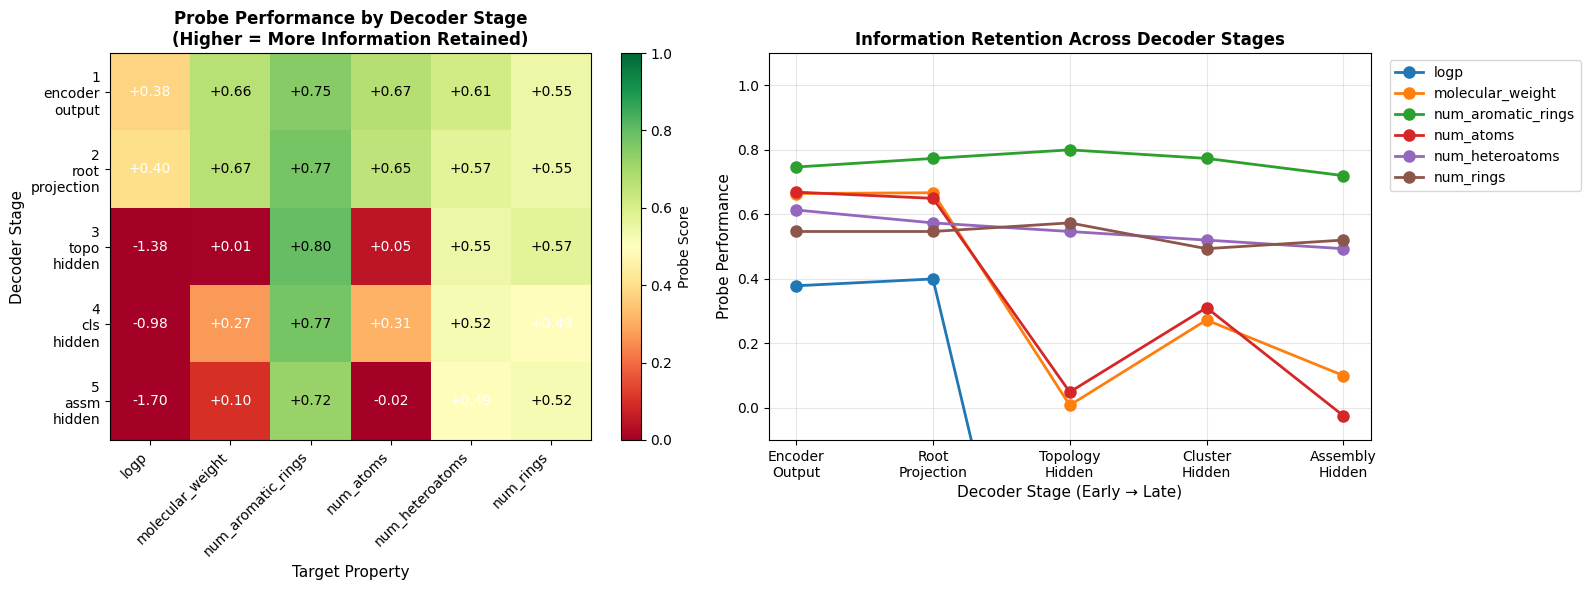

✅ Experiment 1 visualization saved!


In [ ]:
#  Visualize Probing Results
# Pivot for visualization
pivot_df = probe_df.pivot_table(
    index='stage',
    columns='target',
    values='test_score',
    aggfunc='mean'
)

# Reorder stages
stage_order = ['1_encoder_output', '2_root_projection', '3_topo_hidden',
               '4_cls_hidden', '5_assm_hidden']
pivot_df = pivot_df.reindex([s for s in stage_order if s in pivot_df.index])

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Heatmap of probe performance
ax1 = axes[0]
im = ax1.imshow(pivot_df. values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

ax1.set_xticks(range(len(pivot_df.columns)))
ax1.set_xticklabels(pivot_df.columns, rotation=45, ha='right')
ax1.set_yticks(range(len(pivot_df.index)))
ax1.set_yticklabels([s.replace('_', '\n') for s in pivot_df.index])
ax1.set_title('Probe Performance by Decoder Stage\n(Higher = More Information Retained)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Target Property', fontsize=11)
ax1.set_ylabel('Decoder Stage', fontsize=11)

# Add text annotations
for i in range(len(pivot_df.index)):
    for j in range(len(pivot_df.columns)):
        val = pivot_df. iloc[i, j]
        color = 'white' if val < 0.5 else 'black'
        ax1.text(j, i, f'{val:+.2f}', ha='center', va='center', color=color, fontsize=10)

plt.colorbar(im, ax=ax1, label='Probe Score')

# Plot 2: Line plot showing information flow
ax2 = axes[1]
stage_nums = range(len(pivot_df.index))
stage_labels = ['Encoder\nOutput', 'Root\nProjection', 'Topology\nHidden',
                'Cluster\nHidden', 'Assembly\nHidden']

for col in pivot_df.columns:
    ax2.plot(stage_nums, pivot_df[col].values, 'o-', linewidth=2, markersize=8, label=col)

ax2.set_xticks(stage_nums)
ax2.set_xticklabels(stage_labels[: len(stage_nums)])
ax2.set_xlabel('Decoder Stage (Early → Late)', fontsize=11)
ax2.set_ylabel('Probe Performance', fontsize=11)
ax2.set_title('Information Retention Across Decoder Stages', fontsize=12, fontweight='bold')
ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.savefig('part_c_experiment1_probing.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Experiment 1 visualization saved!")

In [ ]:
#Partial Decoding Analysis

print("\n" + "="*70)
print("EXPERIMENT 2: PARTIAL DECODING ANALYSIS")
print("="*70)
print("""
We measure similarity between the target molecule and decoder's partial
reconstruction as decoding progresses step by step.

In hgraph2graph, each decoding "step" corresponds to:
  - Adding a new motif (cluster) to the molecular tree
  - Making attachment decisions

We track:  similarity vs. number of motifs added
""")

def calculate_tanimoto(smi1, smi2):
    """Calculate Tanimoto similarity between two molecules."""
    try:
        mol1 = Chem.MolFromSmiles(smi1)
        mol2 = Chem.MolFromSmiles(smi2)
        if mol1 is None or mol2 is None:
            return None
        fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2, nBits=2048)
        fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2, nBits=2048)
        return DataStructs.TanimotoSimilarity(fp1, fp2)
    except:
        return None

def get_substructure_similarity(target_smi, partial_smi):
    """Calculate how much of the partial structure matches the target."""
    try:
        target_mol = Chem.MolFromSmiles(target_smi)
        partial_mol = Chem.MolFromSmiles(partial_smi)
        if target_mol is None or partial_mol is None:
            return None, None

        # Tanimoto similarity
        tanimoto = calculate_tanimoto(target_smi, partial_smi)

        # Atom coverage (what fraction of target atoms are in partial)
        target_atoms = target_mol.GetNumAtoms()
        partial_atoms = partial_mol.GetNumAtoms()
        coverage = min(partial_atoms / target_atoms, 1.0)

        return tanimoto, coverage
    except:
        return None, None

def analyze_decoding_progression(model, smiles_list, vocab, atom_vocab, max_molecules=50):
    """
    Analyze how reconstruction quality changes during decoding.

    Since the actual decoder is complex, we simulate by:
    1. Getting the motif decomposition of each molecule
    2. Tracking similarity as motifs are "added" one by one
    """
    results = []

    for smi in tqdm(smiles_list[: max_molecules], desc="Analyzing decoding"):
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                continue

            # Get motif decomposition
            hmol = MolGraph(smi)
            num_motifs = len(hmol.mol_tree.nodes())

            if num_motifs < 2:
                continue

            # Simulate partial decoding by using subsets of atoms
            # This approximates what happens as motifs are added
            total_atoms = mol.GetNumAtoms()

            for step in range(1, min(num_motifs + 1, 10)):  # Max 10 steps
                # Fraction of molecule "decoded" at this step
                frac = step / num_motifs
                n_atoms_partial = max(1, int(total_atoms * frac))

                # Get a connected subgraph with n_atoms_partial atoms
                # Start from atom 0 and do BFS
                visited = set([0])
                queue = [0]
                while len(visited) < n_atoms_partial and queue:
                    curr = queue.pop(0)
                    atom = mol.GetAtomWithIdx(curr)
                    for neighbor in atom.GetNeighbors():
                        nidx = neighbor.GetIdx()
                        if nidx not in visited:
                            visited.add(nidx)
                            queue. append(nidx)
                            if len(visited) >= n_atoms_partial:
                                break

                # Extract partial molecule
                try:
                    partial_smi = Chem.MolFragmentToSmiles(mol, list(visited))
                    tanimoto, coverage = get_substructure_similarity(smi, partial_smi)

                    if tanimoto is not None:
                        results.append({
                            'original_smiles': smi,
                            'step': step,
                            'num_motifs': num_motifs,
                            'fraction_complete': frac,
                            'tanimoto':  tanimoto,
                            'atom_coverage': coverage,
                            'partial_smiles': partial_smi
                        })
                except:
                    continue

        except Exception as e:
            continue

    return pd.DataFrame(results)

# Run partial decoding analysis
decoding_df = analyze_decoding_progression(
    model, valid_smiles, vocab, common_atom_vocab, max_molecules=100
)

print(f"\n✅ Analyzed {decoding_df['original_smiles'].nunique()} molecules")
print(f"   Total data points: {len(decoding_df)}")


EXPERIMENT 2: PARTIAL DECODING ANALYSIS

We measure similarity between the target molecule and decoder's partial
reconstruction as decoding progresses step by step.

In hgraph2graph, each decoding "step" corresponds to:
  - Adding a new motif (cluster) to the molecular tree
  - Making attachment decisions

We track:  similarity vs. number of motifs added



Analyzing decoding: 100%|██████████| 100/100 [00:01<00:00, 53.73it/s]


✅ Analyzed 100 molecules
   Total data points: 491
